In [1]:
#Import
import os
import pandas
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#Config
PLOT_ON = False
LOAD_PARTIAL = True
REF_DIR = "in"
MEDIA_DIR = "out"
MODEL_NAME = "model2.pkl"
PIPELINE_NAME = "pipeline2.pkl"

#Load up the test data from the Pickle file
def load_data(b_load_partial_data):
    if not b_load_partial_data:
        DATA_NAME = "mnist_X_train.pkl"
        LABEL_NAME = "mnist_y_train.pkl"
        data_path = os.path.join(REF_DIR, DATA_NAME)
        with open(data_path, "rb") as data_in:
            data_X = pandas.read_pickle(data_in)
        label_path = os.path.join(REF_DIR, LABEL_NAME)
        with open(label_path, "rb") as data_in:
            data_Y = pandas.read_pickle(data_in)
    else:
        LABEL_NAME = "mnist_y_train.pkl"
        label_path = os.path.join(REF_DIR, LABEL_NAME)
        with open(label_path, "rb") as data_in:
            data_Y = pandas.read_pickle(data_in)
        for i in range(4):
            data_name = "mnist_X_train_0"+str(i+1)+".pkl"
            data_path = os.path.join(REF_DIR, data_name)
            if (i == 0):
                with open(data_path, "rb") as data_in:
                    data_X = pandas.read_pickle(data_in)
            else:
                with open(data_path, "rb") as data_in:
                    data_X = np.concatenate((data_X, pandas.read_pickle(data_in)))
    return [data_X, data_Y]
[data_features, data_labels] = load_data(LOAD_PARTIAL)

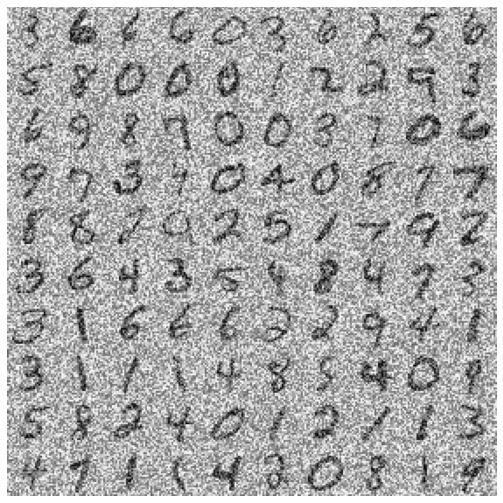

In [2]:
#Plot a sample of the data set
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instances[i:i+1].reshape(size,size) for i in range(instances.shape[0])]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
#%%
plt.figure(figsize=(9,9))
example_images = data_features[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

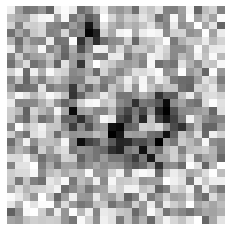

In [2]:
#Split up the data
from sklearn.model_selection import train_test_split

data_train, data_val, label_train, label_val = train_test_split(data_features, data_labels, test_size=0.2)

some_digit = data_train[0:1]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [28]:
# Support Vector Machine
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier

svm_clf = SGDClassifier(loss='hinge', penalty='l2', 
    alpha=1, shuffle=True, learning_rate='adaptive',
    eta0=0.75, power_t=0.25, early_stopping=False)

svm_clf.fit(data_train, label_train)
svm_clf.predict(some_digit)
print(svm_clf.predict(some_digit))
print(svm_clf.decision_function(some_digit))

[8]
[[-187.04986353  -71.19939516  -21.35506344  -40.00316044  -81.12068914
   -45.3569433   -29.75967097  -29.20230546   25.82579872  -44.27995818]]


Test Accuracy Score: 0.8115416666666667
Validation Accuracy Score: 0.7813333333333333
Validation Accuracy Score with Cross-Validation: 0.78


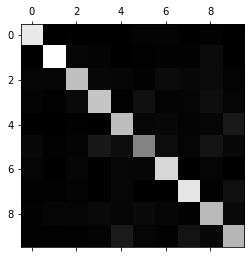

In [29]:
#Some error analysis for these multiclassers
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
#Accuracy score
from sklearn.metrics import accuracy_score
print("Test Accuracy Score: " +str(
        accuracy_score(label_train, svm_clf.predict(data_train), normalize=True, sample_weight=None)))
print("Validation Accuracy Score: " +str(
        accuracy_score(label_val, svm_clf.predict(data_val), normalize=True, sample_weight=None)))
label_train_pred = cross_val_predict(svm_clf, data_train, label_train, cv=5)
print("Validation Accuracy Score with Cross-Validation: "+str(
        accuracy_score(label_train, label_train_pred, normalize=True, sample_weight=None)))


#Confusion Matrix with Cross-Valiation Scores
conf_mx = confusion_matrix(label_train, label_train_pred)
# print("Confusion\n"+str(conf_mx))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [27]:
#Using GridSearchCV for optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_predict

param_grid = [
        {'loss': ['hinge', 'huber'], 'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [1/1, 1/100, 1/10000], 'shuffle': [True, False],
        'early_stopping': [True, False],
        'learning_rate': ['optimal', 'adaptive', 'invscaling'], 'power_t': [0.5, 0.25, 0.10],
        'eta0':[0.25, 0.5, 0.75, 1.0]}
    ]

svm_clf = SGDClassifier(loss='hinge', penalty='l2', 
    alpha=1, shuffle=True, learning_rate='adaptive',
    eta0=0.75, power_t=0.25, early_stopping=False)

grid_search = GridSearchCV(svm_clf, param_grid, cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1)

grid_search.fit(data_features, data_labels)

#Let's see what it tells us the best parameters are
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'eta0': 0.75, 'learning_rate': 'adaptive', 'power_t': 0.25}
SGDClassifier(eta0=0.75, learning_rate='adaptive', power_t=0.25)


Test Accuracy Score: 1.0
Validation Accuracy Score: 0.877
Validation Accuracy Score with Cross-Validation: 0.8674791666666667


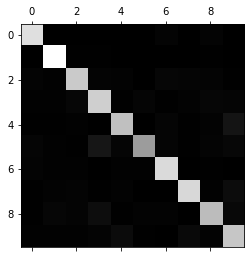

In [3]:
#Some error analysis for these multiclassers
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
#Accuracy score
from sklearn.metrics import accuracy_score
#Similarly, do this with a random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, criterion='gini', 
        oob_score=True)

rf_clf.fit(data_train, label_train)
rf_clf.predict(some_digit)

print("Test Accuracy Score: " +str(
        accuracy_score(label_train, rf_clf.predict(data_train), normalize=True, sample_weight=None)))
print("Validation Accuracy Score: " +str(
        accuracy_score(label_val, rf_clf.predict(data_val), normalize=True, sample_weight=None)))
label_train_pred = cross_val_predict(rf_clf, data_train, label_train, cv=5)
print("Validation Accuracy Score with Cross-Validation: "+str(
        accuracy_score(label_train, label_train_pred, normalize=True, sample_weight=None)))


#Confusion Matrix with Cross-Valiation Scores
conf_mx = confusion_matrix(label_train, label_train_pred)
# print("Confusion\n"+str(conf_mx))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier()

param_grid = [
        {'n_estimators': [1000, 100, 10],
        'criterion': ['gini', 'entropy'],
        'max_features' : [None, 'auto', 'log2'],
        'oob_score' : [True, False]
        }
    ]

grid_search = GridSearchCV(rf_clf, param_grid, cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1)

grid_search.fit(data_features, data_labels)

#Let's see what it tells us the best parameters are
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Test Accuracy Score: 0.8473333333333334
Validation Accuracy Score: 0.8374166666666667
Validation Accuracy Score with Cross-Validation: 0.832625


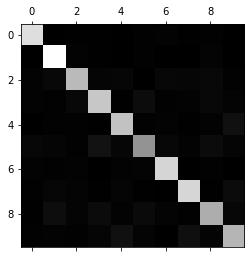

In [5]:
#And also for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logr_clf = LogisticRegression(C=0.0001, fit_intercept=False, multi_class='ovr',
                   penalty='l1', solver='liblinear')

logr_clf.fit(data_train, label_train)
logr_clf.predict(some_digit)

print("Test Accuracy Score: " +str(
        accuracy_score(label_train, logr_clf.predict(data_train), normalize=True, sample_weight=None)))
print("Validation Accuracy Score: " +str(
        accuracy_score(label_val, logr_clf.predict(data_val), normalize=True, sample_weight=None)))
label_train_pred = cross_val_predict(logr_clf, data_train, label_train, cv=5)
print("Validation Accuracy Score with Cross-Validation: "+str(
        accuracy_score(label_train, label_train_pred, normalize=True, sample_weight=None)))


#Confusion Matrix with Cross-Valiation Scores
conf_mx = confusion_matrix(label_train, label_train_pred)
# print("Confusion\n"+str(conf_mx))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
logr_clf = LogisticRegression(multi_class="ovr")

param_grid = [
        {'penalty': ['l2', 'l1'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
        'C' : [1.0, 0.01, 0.0001],
        'fit_intercept': [True, False]
        }
    ]

grid_search = GridSearchCV(logr_clf, param_grid, cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1)

grid_search.fit(data_features, data_labels)

#Let's see what it tells us the best parameters are
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'C': 0.0001, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.0001, fit_intercept=False, multi_class='ovr',
                   penalty='l1', solver='liblinear')


Test Accuracy Score: 0.9029791666666667
Validation Accuracy Score: 0.8555833333333334
Validation Accuracy Score with Cross-Validation: 0.8456458333333333


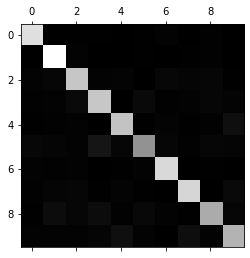

In [5]:
#Ensemble
#Get an ensemble of 3 classifiers and train them to predict

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

svm_clf = SGDClassifier(loss='hinge', penalty='l2', 
    alpha=1, shuffle=True, learning_rate='adaptive',
    eta0=0.75, power_t=0.25, early_stopping=False)
rf_clf = RandomForestClassifier(n_estimators=1000, criterion='gini', 
        oob_score=True)
logr_clf = LogisticRegression(C=0.0001, fit_intercept=False, multi_class='ovr',
                   penalty='l1', solver='liblinear')

voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rf_clf), ('logr', logr_clf)],
    voting='hard')
voting_clf.fit(data_train, label_train)
voting_clf.predict(some_digit)

print("Test Accuracy Score: " +str(
        accuracy_score(label_train, voting_clf.predict(data_train), normalize=True, sample_weight=None)))
print("Validation Accuracy Score: " +str(
        accuracy_score(label_val, voting_clf.predict(data_val), normalize=True, sample_weight=None)))
label_train_pred = cross_val_predict(voting_clf, data_train, label_train, cv=5)
print("Validation Accuracy Score with Cross-Validation: "+str(
        accuracy_score(label_train, label_train_pred, normalize=True, sample_weight=None)))


#Confusion Matrix with Cross-Valiation Scores
conf_mx = confusion_matrix(label_train, label_train_pred)
# print("Confusion\n"+str(conf_mx))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


In [1]:
print(voting_clf)

NameError: name 'voting_clf' is not defined